# Cohort Analysis

 Greg Netols
 
 Decemeber 14, 2017
 
 
 **1 Parsing the Files to Dataframes**
 
 **2 Initial Data Cleaning**
 
 &nbsp;&nbsp;**2.1 Additional Cleaning - Null Clean **
 
 &nbsp;&nbsp;**2.2 Additional Cleaning - Understanding the Data**
 
 &nbsp;&nbsp;&nbsp;&nbsp;**2.2.1 - Are there any duplicate records?**
 
 &nbsp;&nbsp;&nbsp;&nbsp;**2.2.2 - Are there any transaction dates that occur before the join date?**
 
 &nbsp;&nbsp;&nbsp;&nbsp;**2.2.3 - Does each user have the same join_date across all of their transactions?**
 
 &nbsp;&nbsp;&nbsp;&nbsp;**2.2.4 - Fixing the data issues found in 2.2.2 and 2.2.3**
 
 &nbsp;&nbsp;&nbsp;&nbsp;**2.2.5 - Are there any sales amounts that are negative?**
 
 **3 Compute Yearly Time Series Metrics**
 
 **4 Compute Yearly New Users Joined**
 
 **5 Cohort Analysis**
 
 &nbsp;&nbsp;**5.1 Revenue Cohort**
 
 &nbsp;&nbsp;**5.2 Active User Count Cohort**
 
 &nbsp;&nbsp;**5.3 Average Revenue per Active User Cohort**
 
 &nbsp;&nbsp;**5.4 Average Revenue per User Cohort**
 
 &nbsp;&nbsp;**5.5 Lifetime Value Cohort**
 


In [1]:
import numpy as np
import pandas as pd

import locale
locale.setlocale( locale.LC_ALL, 'English_United States.1252')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set(font_scale=1.25)

# 1 Parsing the files to dataframes

Even though all files were downloaded as CSV formatted files the 2013, 2014, and 2015 transaction files are in a tab delimited format. The 2016 transactions were in a true CSV format however there was a parse error on line 310 due to the line containing 8 columns instead of 5. After the row on line 310 was manually cleaned it was discovered that this was a problem throughout the rest of the file. The error_bad_lines parameter was then set to False to get a print out of the remaining bad rows. Seeing that there were only 6 more lines that needed to be fixed it made sense to manually fix them rather than ignoring or creating a programmatic way to handle them.

In [2]:
transactions2013 = pd.read_csv('transactions_2013.csv', sep='\t')
transactions2014 = pd.read_csv('transactions_2014.csv', sep='\t')
transactions2015 = pd.read_csv('transactions_2015.csv', sep='\t')
transactions2016 = pd.read_csv('transactions_2016.csv')

In [3]:
transactions2016.head()

,user,transaction_date,sales_amount,join_date,region
0,257,01-01-2016,19.59,06-03-2008,B
1,307,02-01-2016,61.34,20-08-1999,B
2,378,02-01-2016,44.99,18-03-2004,B
3,253,02-01-2016,16.31,01-08-2009,B
4,4,02-01-2016,18.77,28-07-2011,B


# 2 Initial Data Cleaning

* Through visually looking at the text files it was obvious that the column headers were not consistent across all files. The column names were adjusted for the 2013, 2014, 2015 files to bring them inline with the 2016 file. It was chosen to bring the column names in line with the 2016 file since column names with no spaces are preferred. This will now allow for the concatenation of all four files together making additional data cleaning steps easier.

* Striped unnecessary whitespace from the three string columns (transaction_date, join_date, region).

* Date formatting in the 2013, 2014, and 2015 file is not in a format that can be easily converted to a datetime datatype. A function was created that could be applied to the transaction_date and join_date column to change string months into numeric months. Completed the cleaning of the date columns by converting the datatype to datetime.

* The region column is defined as "The geographical region where the transaction was made" it is expected that this column is limited to a manageable  set of unique values. Which is true. There are 21 unique values and all are individual capital characters.

The goal of the initial data cleaning is to have numeric and date columns constrained to a data type. String values should be confirmed to be formatted in a predictable was or confirmed to occupy a set of expected values. In the end:

* user - constrained to an integer column and will not cause equivalency issues due to leading zeros or due to the integer being represented as a string.

* transaction_date - constrained to a datetime.

* sales_amount - constrained to a float64. I can be confident that there wil be no leading currency symbols, no string representations, and the values will be able to be aggregated.

* join_date - constrained to a datetime.

* region - limited to 21 unique values which is in line with the description of the column.


In [4]:
print( transactions2013.columns)
print( transactions2014.columns)
print( transactions2015.columns)
print( transactions2016.columns)

Index(['user', 'transaction date', 'sales amount', 'join date', 'region'], dtype='object')
Index(['user', 'transaction date', 'sales amount', 'join date', 'region'], dtype='object')
Index(['user', 'transaction date', 'sales amount', 'join date', 'region'], dtype='object')
Index(['user', 'transaction_date', 'sales_amount', 'join_date', 'region'], dtype='object')


In [5]:
# Rename columns to be consistent accross all files
transactions2013.columns = ['user', 'transaction_date', 'sales_amount', 'join_date', 'region']
transactions2014.columns = ['user', 'transaction_date', 'sales_amount', 'join_date', 'region']
transactions2015.columns = ['user', 'transaction_date', 'sales_amount', 'join_date', 'region']

In [6]:
# Concatenate the 4 files to create a single transaction file
dataFrames = [transactions2013, transactions2014, transactions2015, transactions2016]
transactions = pd.concat(dataFrames)
transactions.head()

,user,transaction_date,sales_amount,join_date,region
0,665,January/02/2013,31.77,February/08/2011,E
1,598,January/02/2013,6.20,July/30/2009,I
2,26,January/02/2013,35.03,June/18/2003,B
3,1358,January/02/2013,32.73,January/02/2013,K
4,671,January/02/2013,3.64,May/27/2008,E


In [7]:
# remove any aditional whitespace in the three object(string) columns
transactions['transaction_date'] = transactions['transaction_date'].str.strip()
transactions['join_date'] = transactions['join_date'].str.strip()
transactions['region'] = transactions['region'].str.strip()

In [8]:
print(transactions.dtypes)

user                  int64
transaction_date     object
sales_amount        float64
join_date            object
region               object
dtype: object


In [9]:
monthConversion = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06',
                   'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}

def convert_string_months(row):
    for stringMonth, numberMonth in monthConversion.items():
        row = row.replace(stringMonth, numberMonth)
    return row

In [10]:
# apply the convert_string_months to change written out month values
transactions['transaction_date'] = transactions['transaction_date'].astype(str).apply(convert_string_months)
transactions['join_date'] = transactions['join_date'].astype(str).apply(convert_string_months)

In [11]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['join_date'] = pd.to_datetime(transactions['join_date'])

In [12]:
transactions.head()

,user,transaction_date,sales_amount,join_date,region
0,665,2013-01-02,31.77,2011-02-08,E
1,598,2013-01-02,6.20,2009-07-30,I
2,26,2013-01-02,35.03,2003-06-18,B
3,1358,2013-01-02,32.73,2013-01-02,K
4,671,2013-01-02,3.64,2008-05-27,E


In [13]:
print(transactions.dtypes)

user                         int64
transaction_date    datetime64[ns]
sales_amount               float64
join_date           datetime64[ns]
region                      object
dtype: object


In [14]:
print( len(transactions['region'].unique()) )
print(transactions['region'].unique())

21
['E' 'I' 'B' 'K' 'D' 'H' 'M' 'S' 'C' 'G' 'F' 'J' 'O' 'A' 'L' 'N' 'P' 'Q'
 'R' 'T' 'U']


## 2.1 Additional Cleaning - Null Clean up

Before any null values are handled there exists 3 sales_amounts that are null along with 11 join_dates.

* null sales amounts will be set to 0. It is possible that a user could make a transaction without there being a sales amount. Perhaps the business released vouchers for free items which when used still created a transaction with a null sales amount.
* The join_date is defined as the 'date of the customer's first purchase' if it is null it will be populated with the earliest transaction_date that exists for that user.

In [15]:
print( transactions.isnull().sum(axis=0) )

user                 0
transaction_date     0
sales_amount         3
join_date           11
region               0
dtype: int64


In [16]:
transactions[transactions['sales_amount'].isnull()]

,user,transaction_date,sales_amount,join_date,region
2146,202,2013-03-09,NaN,2003-01-25,B
2896,4977,2014-03-11,NaN,2013-12-20,B
3605,3591,2014-03-28,NaN,2013-08-20,A


In [17]:
transactions['sales_amount'] = transactions['sales_amount'].fillna(0)
transactions[transactions['sales_amount'].isnull()]

,user,transaction_date,sales_amount,join_date,region


In [18]:
transactions[transactions['join_date'].isnull()]

,user,transaction_date,sales_amount,join_date,region
786,7253,2013-02-01,59.50,NaT,C
5525,3362,2013-06-01,23.47,NaT,B
5545,7253,2013-06-01,11.31,NaT,C
6017,7253,2013-06-11,20.23,NaT,C
7235,7253,2013-07-06,34.02,NaT,C
11156,4080,2013-09-27,56.52,NaT,D
14344,3362,2013-12-08,6.89,NaT,B
14704,7253,2013-12-13,34.01,NaT,C
1586,3362,2014-02-08,23.43,NaT,B
10753,3362,2014-09-21,12.21,NaT,B


In [19]:
transactions['min_transaction_date'] = transactions.groupby('user')['transaction_date'].transform('min')
transactions['join_date'] = transactions['join_date'].fillna(transactions['min_transaction_date'])
transactions = transactions.drop('min_transaction_date', axis=1)

transactions[transactions['join_date'].isnull()]

,user,transaction_date,sales_amount,join_date,region


In [20]:
print( transactions.isnull().sum(axis=0) )

user                0
transaction_date    0
sales_amount        0
join_date           0
region              0
dtype: int64


## 2.2 Additional Cleaning - Understanding the Data

At this point i have four questions that i want to answer before i begin extracting value from the data. These questions may inspire additional data cleaning steps that need to be performed.

### 2.2.1 - Are there any duplicate records?

I will need to decide if these should be considered duplicate events and removed, or if they are the user performing the same action twice in one day.

In [21]:
print(any(transactions.duplicated()))
print(sum(transactions.duplicated(keep=False)))

True
329


In [22]:
transactions[transactions.duplicated(['user', 'transaction_date', 'sales_amount'], keep=False)].sort_values(by=['user', 'transaction_date', 'sales_amount']).head(10)

,user,transaction_date,sales_amount,join_date,region
6457,16,2013-06-21,4.94,2001-01-01,B
6461,16,2013-06-21,4.94,2001-01-01,B
874,124,2016-01-30,22.23,2010-11-02,J
879,124,2016-01-30,22.23,2010-11-02,J
1735,338,2016-02-22,19.26,2009-07-19,H
1736,338,2016-02-22,19.26,2009-07-19,H
14450,369,2013-12-10,9.75,2005-11-19,B
14453,369,2013-12-10,9.75,2005-11-19,B
7513,584,2015-08-08,11.32,2010-12-02,M
7518,584,2015-08-08,11.32,2010-12-02,M


There are definitely duplicates. However duplicates will not be removed. It is possible that two different items could be purchased by the same user, on the same date, and for the same amount.

### 2.2.2 - Are there any transaction dates that occur before the join date?
The join_date column is defined as "the date of a customer's first purchase" while the transaction_date is defined as "the date when the transaction was made". From the column definition there should be no join_dates that occur after the minimum transaction_date for a customer.

In [23]:
print( len(transactions[transactions['transaction_date'] < transactions['join_date']]) )

6990


In [24]:
print( len(transactions[transactions['transaction_date'] >= transactions['join_date']]) )

44485


There are 6990 records that contain a join date that occurs after the tansaction.


### 2.2.3 - Does each user have the same join_date across all of their transactions?    

Since join_date is defined as "The date of a customers first purchase" a customer should not have multiple join dates in the transaction files.

In [25]:
transactions[['user', 'join_date']].groupby(['user', 'join_date']).agg({'join_date': 'count'}).head(10)

join_date
user join_date            
1    2012-02-13          5
2    2004-06-29         54
3    2006-03-27         12
4    2011-07-28        201
5    2002-09-17         17
6    2007-11-08          3
7    2009-04-05          3
     2009-05-04         14
8    2002-12-21         19
9    2001-01-01         17

From the above output it is visible that not all users have the same join_date across all of their transactions. User 7 has their join dates divided amongst 2009-04-05 and 2009-05-04.

### 2.2.4 - Fixing the data issues found in 2.2.2 and 2.2.3

To bring the join_date column in line with its business definition join_date will be fixed in a two step process. If this is not resolved before the cohort analysis the cohort triangles will look more like cohort rectangles.

1. For each row set join_date equal to the minimum of join_date and transaction_date
2. For each user set their join_date for all transaction equal to their minimum join_date on the transaction file.

This will ensure that no rows will contain a join_date that comes after the transaction_date, and that each user has only one join_date.

In [26]:
transactions['join_date'] = transactions[['transaction_date', 'join_date']].min(axis=1)

transactions['join_date'] = transactions[['user', 'join_date']].groupby(['user']).transform('min')

In [27]:
print( len(transactions[transactions['transaction_date'] < transactions['join_date']]) )

0


In [28]:
transactions[['user', 'join_date']].groupby(['user', 'join_date']).agg({'join_date': 'count'}).head(10)

,,join_date
user,join_date,
1,2012-02-13,5
2,2004-06-29,54
3,2006-03-27,12
4,2011-07-28,201
5,2002-09-17,17
6,2007-11-08,3
7,2009-04-05,17
8,2002-12-21,19
9,2001-01-01,17


In [29]:
print( transactions[['user', 'join_date']].groupby(['user', 'join_date']).agg({'join_date': 'count'}).shape )

(10000, 1)


Now there exists no transaction dates that come before the join_date. There are also no users that have more than one unique join_date across their set of transactions.

### 2.2.5 - Are there any sales amounts that are negative?

These could indicate that the system is recording returns or adjustments. Should negative sales amounts contribute to revenue summations. This might depend on how strict of an accountant will be analyzing this report. For this challenge i will leave negative sales amounts unchanged.

In [30]:
print( len(transactions[transactions['sales_amount'] < 0]) )

41


In [31]:
transactions[transactions['sales_amount'] < 0].head()

,user,transaction_date,sales_amount,join_date,region
3072,6149,2013-03-30,-3.780000e+00,2013-03-30,C
3489,9461,2013-04-10,-4.110000e+00,2013-04-10,C
4084,9461,2013-04-26,-4.020000e+00,2013-04-10,C
5065,258,2013-05-22,-1.070000e-14,2005-12-23,B
7290,4514,2013-07-08,-1.105000e+01,2013-07-08,F


There are negative sales amounts. I will be treating these as returns / adjustments for previous transactions and i will not be removing them.

# 3 Compute Yearly Time Series Metrics

a. Revenue

    Total sales during the year

b. Active User Count

    Total unique users that completed a transaction

c. Average Recenue Per Active User

    (Revenue) / (Active User Count)

In [32]:
timeSeries = transactions.copy()

groupedTimeSeries = timeSeries.groupby(timeSeries['transaction_date'].dt.year)

groupedTimeSeries = groupedTimeSeries.agg({'sales_amount': 'sum', 'user': 'nunique'})

groupedTimeSeries['Average Revenue Per Active User'] = groupedTimeSeries['sales_amount'] / groupedTimeSeries['user']

In [33]:
# rename columns and index for display purposes
groupedTimeSeries.index.name = 'Transaction Year'
groupedTimeSeries.columns = ['Revenue', 'Active User Count', 'Average Revenue Per Active User']

In [34]:
# Format dollar values
groupedTimeSeries['Revenue'] = groupedTimeSeries['Revenue'].map(locale.currency)
groupedTimeSeries['Average Revenue Per Active User'] = groupedTimeSeries['Average Revenue Per Active User'].map(locale.currency)

In [35]:
timeSeriesMetrics = groupedTimeSeries.rename_axis('Metrics', axis='columns').transpose()

timeSeriesMetrics

Transaction Year,2013,2014,2015,2016
Metrics,,,,
Revenue,$577760.22,$701242.97,$542004.20,$170035.56
Active User Count,5877,5412,4676,2182
Average Revenue Per Active User,$98.31,$129.57,$115.91,$77.93


# 4 Compute Yearly New Users Joined

In [36]:
newUsers = transactions.copy()

newUsers = newUsers.groupby(newUsers['join_date'].dt.year)
newUsers = newUsers.agg({'user': 'nunique'})

newUsers.index.name = 'Year'
newUsers.columns = ['New Users Joined']
newUsers.index = newUsers.index.astype(int)

In [37]:
#Check that the sum of New Users Joined adds up to the number of unique users
print( newUsers['New Users Joined'].sum() )

print( len(transactions.user.unique()) )

10000
10000


In [38]:
newUsers

,New Users Joined
Year,
1999,36
2000,8
2001,49
2002,49
2003,178
2004,178
2005,163
2006,199
2007,270


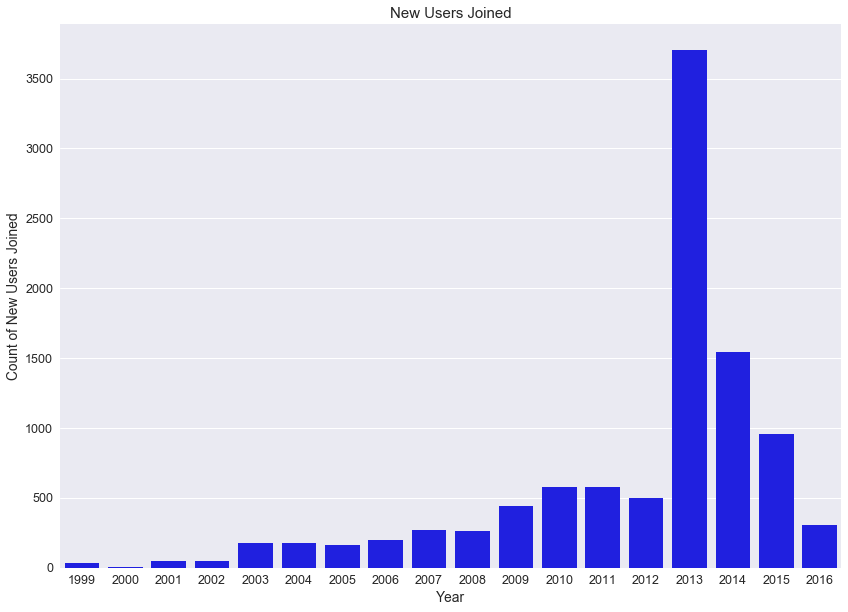

In [39]:
plt.figure(figsize=(14, 10))
ax = sns.barplot(newUsers.index, y=newUsers['New Users Joined'], data=newUsers, color = 'blue')
ax.set(xlabel='Year', ylabel='Count of New Users Joined', title='New Users Joined')
plt.show()

# 5 Cohort Analysis

Group users into cohorts based off of the year that they made their first purchase (join_date).

In [40]:
transactionCohort = transactions.copy()

transactionCohort['cohort_year'] = transactionCohort['join_date'].dt.year.astype(int)
transactionCohort['transaction_year'] = transactionCohort['transaction_date'].dt.year.astype(int)

transactionCohort.head()

,user,transaction_date,sales_amount,join_date,region,cohort_year,transaction_year
0,665,2013-01-02,31.77,2011-02-08,E,2011,2013
1,598,2013-01-02,6.20,2009-07-30,I,2009,2013
2,26,2013-01-02,35.03,2003-06-18,B,2003,2013
3,1358,2013-01-02,32.73,2013-01-02,K,2013,2013
4,671,2013-01-02,3.64,2008-05-27,E,2008,2013


Group transactions by the users cohort year and the transaction year. These groupings will be at the same granularity as the individual cells on the cohort triangle.

In [41]:
groupedCohort = transactionCohort.groupby(['cohort_year', 'transaction_year'])

cohorts = groupedCohort.agg({'sales_amount': 'sum',
                             'user': 'nunique'})

cohorts['average_revenue_per_active_user'] = cohorts['sales_amount'] / cohorts['user']

cohorts.columns = [ 'revenue', 'active_user_count', 'average_revenue_per_active_user']

cohorts.head(10)

revenue  active_user_count  \
cohort_year transaction_year                                
1999        2013               4704.83                 28   
            2014               4086.97                 32   
            2015               2645.03                 26   
            2016                803.01                 17   
2000        2013                749.36                  7   
            2014               1965.68                  6   
            2015                949.22                  7   
            2016                387.68                  3   
2001        2013              10616.15                 44   
            2014              10355.50                 41   

                              average_revenue_per_active_user  
cohort_year transaction_year                                   
1999        2013                                   168.029643  
            2014                                   127.717813  
            2015                                   101.731923  
            2016                                    47.235882  
2000        2013                                   107.051429  
            2014                                   327.613333  
            2015                                   135.602857  
            2016                                   129.226667  
2001        2013                                   241.276136  
            2014                                   252.573171

To compute the cohort triangle for Average Revenue Per User the cummulative sum of users that have joined up until the transaction date will need to be known. This can easily be added to the data frame by joining the results from part 4 to the cohorts triangle data table.

In [42]:
# Copy newUsers and compute the cummulative sum before joining
cummulativeNewUsers = newUsers.copy()
cummulativeNewUsers['total_users'] = cummulativeNewUsers['New Users Joined'].cumsum()

cohortsJoined = pd.merge(cohorts.reset_index(), cummulativeNewUsers.reset_index(), how='left', left_on='cohort_year', right_on='Year').set_index(['cohort_year', 'transaction_year'])

cohortsJoined = cohortsJoined.drop('New Users Joined', axis=1)

cohortsJoined['average_revenue_per_user'] = cohortsJoined['revenue'] / cohortsJoined['total_users']

cohortsJoined['lifetime_value'] = cohortsJoined.reset_index().groupby(['cohort_year', 'transaction_year'])['average_revenue_per_user'].sum().groupby(level=[0]).cumsum()

cohortsJoined.head(10)

revenue  active_user_count  \
cohort_year transaction_year                                
1999        2013               4704.83                 28   
            2014               4086.97                 32   
            2015               2645.03                 26   
            2016                803.01                 17   
2000        2013                749.36                  7   
            2014               1965.68                  6   
            2015                949.22                  7   
            2016                387.68                  3   
2001        2013              10616.15                 44   
            2014              10355.50                 41   

                              average_revenue_per_active_user  Year  \
cohort_year transaction_year                                          
1999        2013                                   168.029643  1999   
            2014                                   127.717813  1999   
            2015                                   101.731923  1999   
            2016                                    47.235882  1999   
2000        2013                                   107.051429  2000   
            2014                                   327.613333  2000   
            2015                                   135.602857  2000   
            2016                                   129.226667  2000   
2001        2013                                   241.276136  2001   
            2014                                   252.573171  2001   

                              total_users  average_revenue_per_user  \
cohort_year transaction_year                                          
1999        2013                       36                130.689722   
            2014                       36                113.526944   
            2015                       36                 73.473056   
            2016                       36                 22.305833   
2000        2013                       44                 17.030909   
            2014                       44                 44.674545   
            2015                       44                 21.573182   
            2016                       44                  8.810909   
2001        2013                       93                114.152151   
            2014                       93                111.349462   

                              lifetime_value  
cohort_year transaction_year                  
1999        2013                  130.689722  
            2014                  244.216667  
            2015                  317.689722  
            2016                  339.995556  
2000        2013                   17.030909  
            2014                   61.705455  
            2015                   83.278636  
            2016                   92.089545  
2001        2013                  114.152151  
            2014                  225.501613

## 5.1 Revenue Cohort

Total revenue by year of first purchase c and by year of purchase t 

In [43]:
revenueCohort = cohortsJoined['revenue'].unstack(0).transpose()
revenueCohort

transaction_year,2013,2014,2015,2016
cohort_year,,,,
1999,4704.83,4086.97,2645.03,803.01
2000,749.36,1965.68,949.22,387.68
2001,10616.15,10355.50,11721.77,2512.05
2002,4751.16,5386.09,5354.17,1372.95
2003,10036.57,11092.85,9599.05,3173.26
2004,10869.31,10138.01,10010.85,3189.49
2005,7434.87,8004.49,6210.45,2658.62
2006,15421.74,9462.83,7927.08,1884.27
2007,12617.83,13129.56,12443.68,3209.10


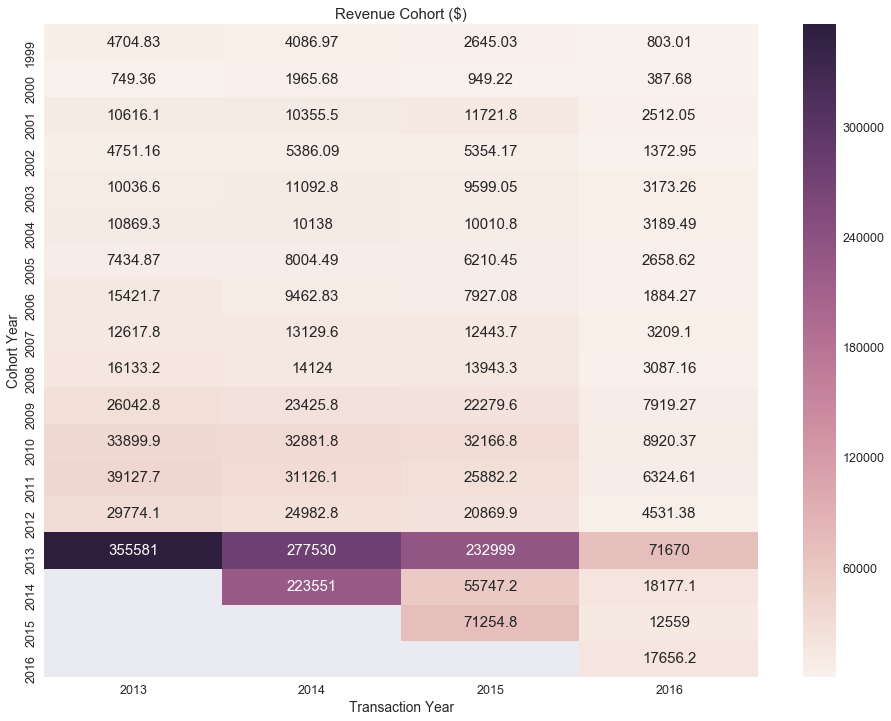

In [44]:
plt.figure(figsize=(16, 12))
plt.title('Revenue Cohort ($)')
htmp = sns.heatmap(revenueCohort, annot=True, fmt='g')
htmp.set(xlabel='Transaction Year', ylabel='Cohort Year')
plt.show()

## 5.2 Active User Count Cohort

Total revenue by year of first purchase c and by year of purchase t 

In [45]:
activeUserCountCohort = cohortsJoined['active_user_count'].unstack(0).transpose()
activeUserCountCohort

transaction_year,2013,2014,2015,2016
cohort_year,,,,
1999,28.0,32.0,26.0,17.0
2000,7.0,6.0,7.0,3.0
2001,44.0,41.0,39.0,19.0
2002,41.0,40.0,34.0,18.0
2003,95.0,102.0,85.0,42.0
2004,104.0,106.0,91.0,38.0
2005,89.0,85.0,74.0,33.0
2006,120.0,107.0,85.0,33.0
2007,158.0,149.0,127.0,51.0


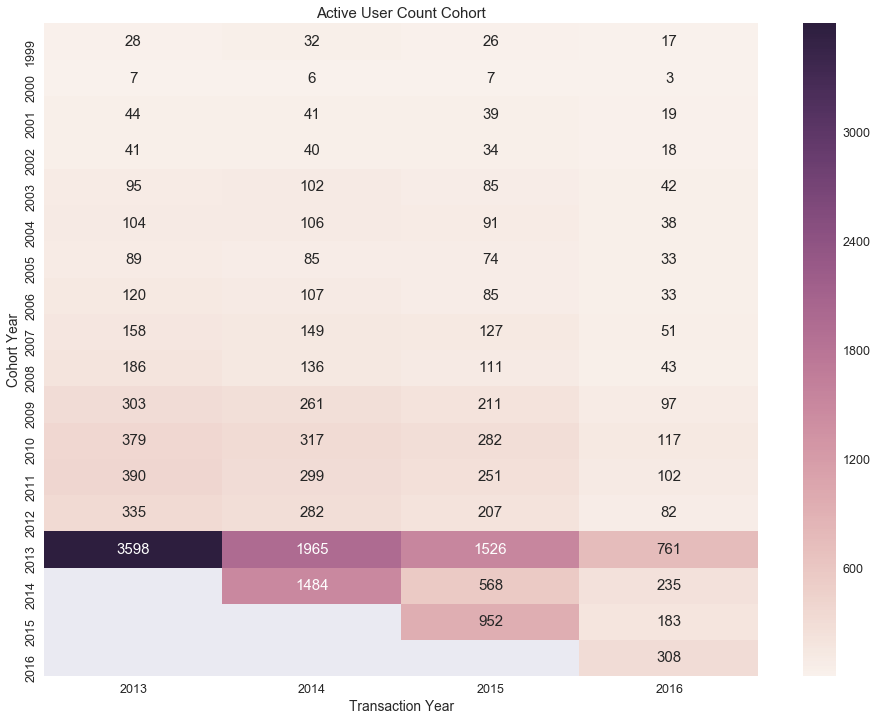

In [46]:
plt.figure(figsize=(16, 12))
plt.title('Active User Count Cohort')
htmp = sns.heatmap(activeUserCountCohort, annot=True, fmt='g')
htmp.set(xlabel='Transaction Year', ylabel='Cohort Year')
plt.show()

## 5.3 Average Revenue per Active User Cohort

Revenue (at year t, cohort year c) / Active User Count (at year t, cohort year c)

In [47]:
averageRevenueActiveUserCohort = cohortsJoined['average_revenue_per_active_user'].unstack(0).transpose()
averageRevenueActiveUserCohort

transaction_year,2013,2014,2015,2016
cohort_year,,,,
1999,168.029643,127.717813,101.731923,47.235882
2000,107.051429,327.613333,135.602857,129.226667
2001,241.276136,252.573171,300.558205,132.213158
2002,115.881951,134.652250,157.475588,76.275000
2003,105.648105,108.753431,112.930000,75.553810
2004,104.512596,95.641604,110.009341,83.933947
2005,83.537865,94.170471,83.925000,80.564242
2006,128.514500,88.437664,93.259765,57.099091
2007,79.859684,88.117852,97.981732,62.923529


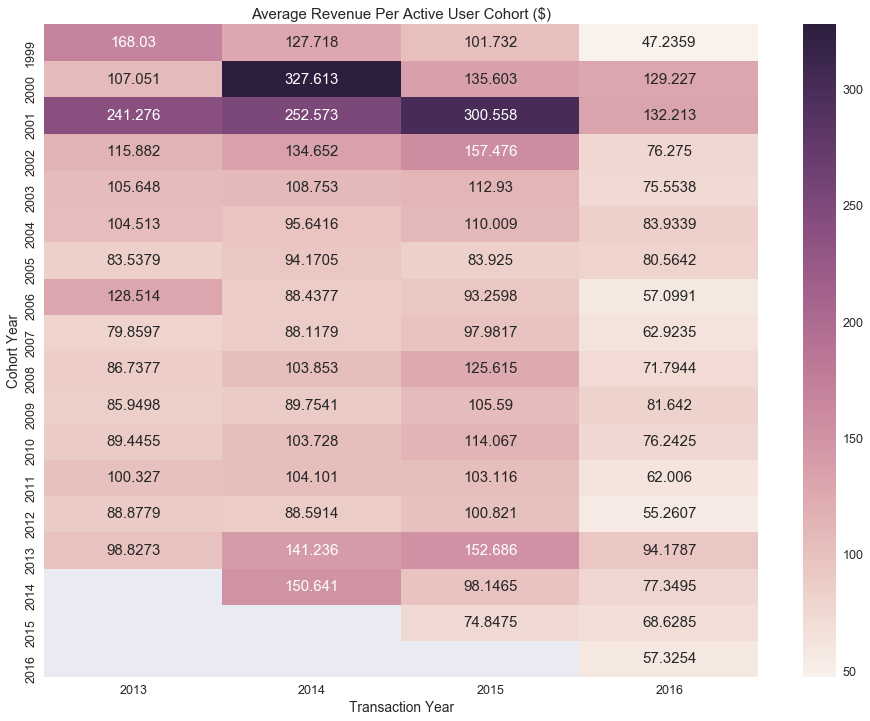

In [48]:
plt.figure(figsize=(16, 12))
plt.title('Average Revenue Per Active User Cohort ($)')
htmp = sns.heatmap(averageRevenueActiveUserCohort, annot=True, fmt='g')
htmp.set(xlabel='Transaction Year', ylabel='Cohort Year')
plt.show()

## 5.4 Average Revenue per User Cohort

Revenue (at year t, cohort year c) / New Users Joined (at cohort year c)

In [49]:
averageRevenueUserCohort = cohortsJoined['average_revenue_per_user'].unstack(0).transpose()
averageRevenueUserCohort

transaction_year,2013,2014,2015,2016
cohort_year,,,,
1999,130.689722,113.526944,73.473056,22.305833
2000,17.030909,44.674545,21.573182,8.810909
2001,114.152151,111.349462,126.040538,27.011290
2002,33.458873,37.930211,37.705423,9.668662
2003,31.364281,34.665156,29.997031,9.916437
2004,21.825924,20.357450,20.102108,6.404598
2005,11.247912,12.109667,9.395537,4.022118
2006,17.932256,11.003291,9.217535,2.191012
2007,11.166221,11.619080,11.012106,2.839912


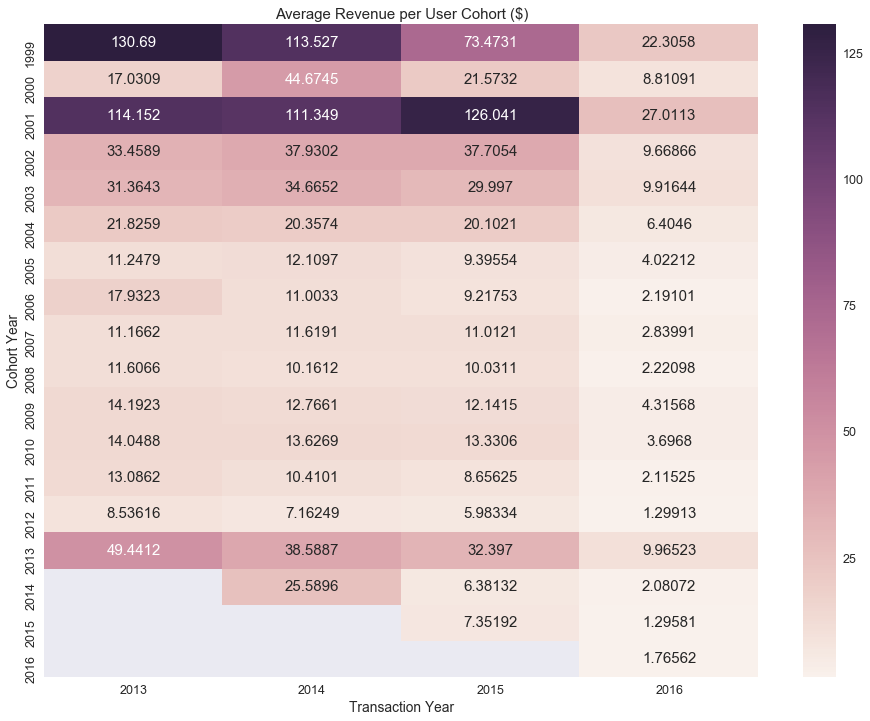

In [50]:
plt.figure(figsize=(16, 12))
plt.title('Average Revenue per User Cohort ($)')
htmp = sns.heatmap(averageRevenueUserCohort, annot=True, fmt='g')
htmp.set(xlabel='Transaction Year', ylabel='Cohort Year')
plt.show()

## 5.5 Lifetime Value Cohort

Cumulative Sum of Average Revenue Per User along cohort year c

In [51]:
lifeTimeValueCohort = cohortsJoined['lifetime_value'].unstack(0).transpose()
lifeTimeValueCohort

transaction_year,2013,2014,2015,2016
cohort_year,,,,
1999,130.689722,244.216667,317.689722,339.995556
2000,17.030909,61.705455,83.278636,92.089545
2001,114.152151,225.501613,351.542151,378.553441
2002,33.458873,71.389085,109.094507,118.763169
2003,31.364281,66.029437,96.026469,105.942906
2004,21.825924,42.183373,62.285482,68.690080
2005,11.247912,23.357579,32.753116,36.775234
2006,17.932256,28.935547,38.153081,40.344093
2007,11.166221,22.785301,33.797407,36.637319


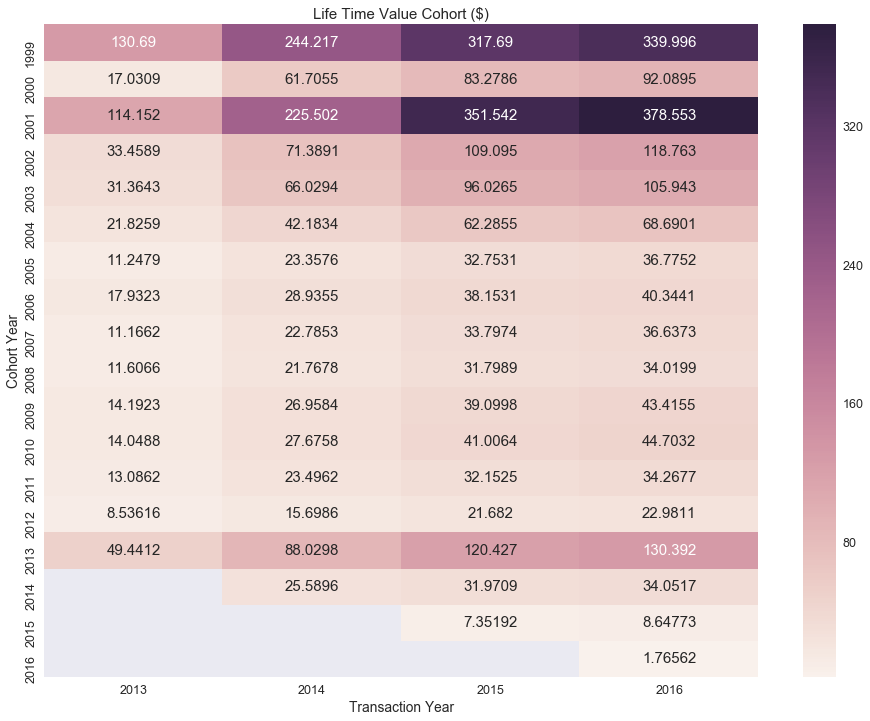

In [52]:
plt.figure(figsize=(16, 12))
plt.title('Life Time Value Cohort ($)')
htmp = sns.heatmap(lifeTimeValueCohort, annot=True, fmt='g')
htmp.set(xlabel='Transaction Year', ylabel='Cohort Year')
plt.show()

For the purpose of keeping the report concise I will not be doing the extra credit. However, building the reports for each region would be as simple as filtering the transactions using the following statement prior to building the tables and charts.

transactions[transactions['region'] == 'region value']

To create the reports for monthly groupings instead of yearly groupings would involve first representing month/year combinations as an integer formatted as yyyymm. This integer representation of the year/month could then be used instead of the year when constructing the time series metrics, new users joined, and cohort triangles.

